# Motivation

The reason why I was psyched about the *low mass* events cut was b/c this seems like a natural way to have a dedicated $\kappa_\lambda$ attack, and not completely peace out on this result.

In [47]:
import pandas as pd
import numpy as np
from itertools import product
from glob import glob
import uproot
import pyhf

import os
os.sys.path += ['../RRevolution/code','../code', "../PyATLASstyle/", '../PAG-opt/']
from analysis import getXhh
from processMNTs import getLambdaWeights
from utils import L
from eventDisplays import rainbow_text
from plots import draw_SR, draw_VR, draw_CR

import matplotlib.pyplot as plt
from matplotlib import gridspec

import logging   
for name in logging.Logger.manager.loggerDict.keys():
    logging.getLogger(name).setLevel(logging.CRITICAL)
        
plt.rcParams.update({'figure.max_open_warning': 0})

# Let's do ATLAS style plots too!
import matplotlib as mpl
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

../PyATLASstyle/PyATLASstyle.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


**Load in the data**

In [76]:
mc = 'mc16d'

sFile = '../data/RR/NNT_DEC20_{}/MC/600043_{}/NanoNTuple.root'

tName = 'fullmassplane'
scols=['m_hh','ntag','m_h1','m_h2','pass_vbf_sel','mc_sf','truth_mhh',
       'kinematic_region']

In [84]:
dhh = uproot.open(sFile.format('DHH',mc))[tName].pandas.df(scols)
dhh_vec = uproot.open(sFile.format('DHH_VEC',mc))[tName].pandas.df(scols)

min_dR = uproot.open(sFile.format('MDR_VEC',mc))[tName].pandas.df(scols)

for df in [dhh,dhh_vec,min_dR]:
    df['truth_mhh'] *= 0.001


**Massplanes**

I wasn't looking @ low mass for the SR center optimzation - so let's check the fullmassplanes for this, and then with a low mass cut!!

In [4]:
x0,y0 = 120, 110
x1,y1 = 124, 117

In [15]:
figDir = f'figures/SMNR_{mc}-NNT_DEC20/'

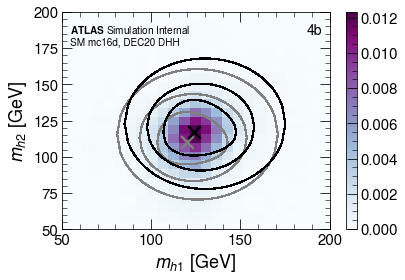

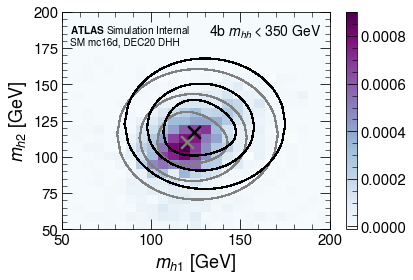

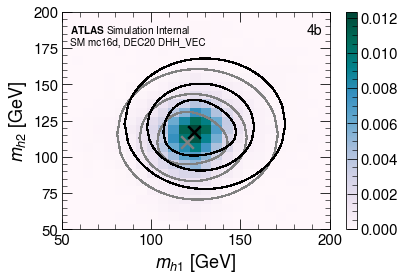

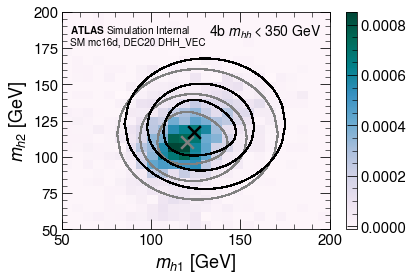

In [25]:
for df,cmap,sort in zip([dhh, dhh_vec],['BuPu','PuBuGn'],['','_VEC']):
    
    fmp = "$\mathbf{ATLAS}$ Simulation Internal\n"
    fmp += f"SM {mc}, DEC20 DHH{sort}"
    
    m = (df.ntag>=4) & (~df.pass_vbf_sel)
        
    for mi,t,ti in zip([True,df.m_hh<350],['',' $m_{hh} < 350$ GeV'],['','m_hh_lr_350']):

        plt.figure()
        plt.hist2d(*df.loc[m&mi,['m_h1','m_h2']].values.T,25,[(50,200),(50,200)],
                   cmap=cmap,weights=df.loc[m&mi,'mc_sf'])
        plt.colorbar()
        plt.xlabel('$m_{h1}$ [GeV]',fontsize=18)
        plt.ylabel('$m_{h2}$ [GeV]',fontsize=18)

        ax = plt.gca()
        plt.text(.97,.95,f'4b{t}',transform=ax.transAxes,ha='right',va='top',fontsize=14)
        plt.text(0.03,0.95,fmp,transform=ax.transAxes,ha='left',va='top',fontsize=10)

        # Overlay our region definitions
        for xi,yi,c,rTag in zip([x0,x1],[y0,y1],['grey','k'],['old','old_new']):

            plt.scatter([xi],[yi],160,marker='x',color=c)
            for f in [draw_SR,draw_VR,draw_CR]:
                x,y = f(xi,yi)
                plt.plot(x,y,c,lw=1.2)

            plt.savefig(f'{figDir}/mp_4b_Xwt{ti}{sort}.pdf', bbox_inches='tight')


In [86]:
for df in [dhh,dhh_vec,min_dR]:
    
    df['Xhh_new'] = getXhh(*df[['m_h1','m_h2']].values.T,x1,y1)
    getLambdaWeights(df)

**Compare scalar vs vector sort for signal yield**

In [114]:
text = "$\mathbf{ATLAS}$ Simulation Internal\n"
text += f"{mc}, DEC20 NNT"

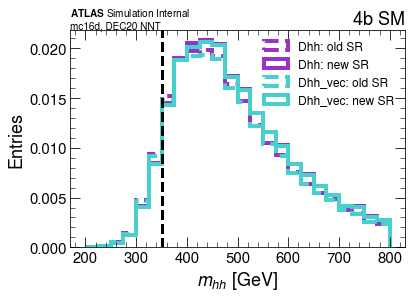

In [115]:
for df,c,sort in zip([dhh, dhh_vec],['darkorchid','mediumturquoise'],['','_vec']):

    mi = (df.ntag>=4) & (~df.pass_vbf_sel) 
    
    m1 = (df.kinematic_region==0) & mi
    m2 = (df.Xhh_new<1.6) & mi
    
    plt.hist(df.loc[m1,'m_hh'],24,(200,800),histtype='step',lw=4,
             color=c,label=f'Dhh{sort}: old SR',ls='--',
             weights=df.loc[m1,'mc_sf'])
    
    plt.hist(df.loc[m2,'m_hh'],24,(200,800),histtype='step',lw=4,
             color=c,label=f'Dhh{sort}: new SR',ls='-',
             weights=df.loc[m2,'mc_sf'])

plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('Entries',fontsize=18)
plt.legend(fontsize=12)

ylim = plt.ylim()
plt.plot([350]*2,ylim,'k--')
plt.ylim(ylim)

ax = plt.gca()
plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes,fontsize=10)

plt.title('4b SM',loc='right')

plt.show()

- old SR definitely has better signal efficiency than new SR
- It seems like vector is slightly better than scalar here as well.

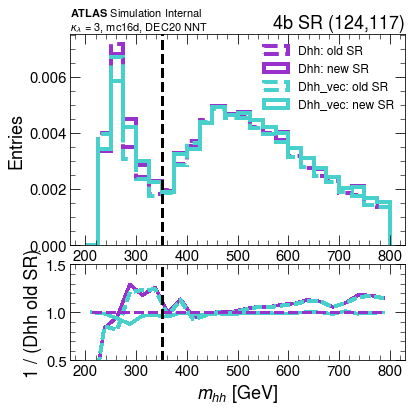

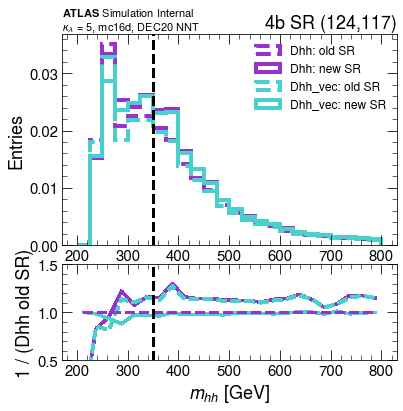

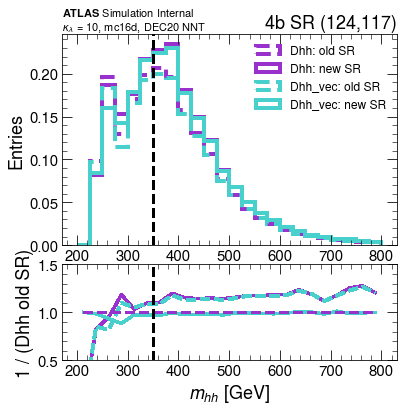

In [147]:
for kl in [3,5,10]:

    ti = "$\mathbf{ATLAS}$ Simulation Internal\n"
    ti += f"$\kappa_\lambda$ = {kl}, {mc}, DEC20 NNT"
    
    fig = plt.figure(figsize=(6,6))
    gs = gridspec.GridSpec(3,1)
    ax1 = fig.add_subplot(gs[:2,0])
    ax2 = fig.add_subplot(gs[2,0],sharex=ax1)

    for df,c,sort in zip([dhh, dhh_vec],['darkorchid','mediumturquoise'],['','_vec']):

        mi = (df.ntag>=4) & (~df.pass_vbf_sel) 

        m1 = (df.kinematic_region==0) & mi
        m2 = (df.Xhh_new<1.6) & mi

        n1,e,_ = ax1.hist(df.loc[m1,'m_hh'],24,(200,800),histtype='step',lw=4,
                          color=c,label=f'Dhh{sort}: old SR',ls='--',
                          weights=df.loc[m1,f'w_k{kl}'])

        n2,_,_ =  ax1.hist(df.loc[m2,'m_hh'],24,(200,800),histtype='step',lw=4,
                           color=c,label=f'Dhh{sort}: new SR',ls='-',
                            weights=df.loc[m2,f'w_k{kl}'])

        if c == 'darkorchid':
            n0 = n1
            xx = 0.5 * (e[1:] + e[:-1])
            ax2.plot(xx, n2/n0, color=c)
        else:
            ax2.plot(xx, n1/n0, color=c)
            ax2.plot(xx, n2/n0, color=c,ls='--')

    ax2.set_xlabel('$m_{hh}$ [GeV]',fontsize=18)
    ax1.set_ylabel('Entries',fontsize=18)
    ax2.set_ylabel('1 / (Dhh old SR)',fontsize=18)
    ax1.legend(fontsize=12)
    
    ax1.set_title(f'4b SR (124,117)',loc='right')
    plt.text(0,1,ti,ha='left',va='bottom',transform=ax1.transAxes,fontsize=11)    
    
    #for ax in [ax1,ax2]:
    ylim = ax1.get_ylim()
    ax1.plot([350]*2,ylim,'k--')
    ax1.set_ylim(ylim)

    plt.plot(xx,np.ones_like(xx),color='darkorchid',ls='--')
    ylim = [0.5,1.5]
    ax2.plot([350]*2,ylim,'k--')
    ax2.set_ylim(ylim)

    plt.savefig(f'{figDir}/m_hh_kl_{kl}_dhh_configs.pdf',bbox_inches='tight')
    
plt.show()

Hmmmmm - *none* of these are picking up the interference dip... **why not**????

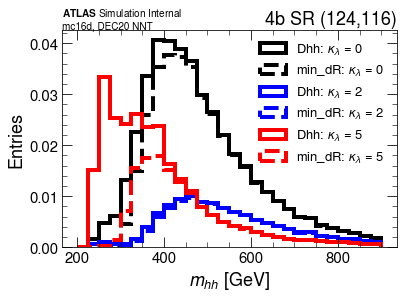

In [126]:
kls = [0,2,5]
kl_tag = '_'.join(f'{kl}' for kl in kls)

for kl,c in zip(kls,['k','b','r']):

    m1 = (dhh.Xhh_new<1.6) & (dhh.ntag>=4) & (~dhh.pass_vbf_sel) 

    plt.hist(dhh.loc[m1,'m_hh'],28,(200,900),histtype='step',lw=4,
             color=c,label=f'Dhh: $\kappa_\lambda$ = {kl}',
             weights=dhh.loc[m1,f'w_k{kl}'])
    
    m2 = (min_dR.Xhh_new<1.6) & (min_dR.ntag>=4) & (~min_dR.pass_vbf_sel) 
    plt.hist(min_dR.loc[m2,'m_hh'],28,(200,900),histtype='step',lw=4,ls='--',
             color=c,label=f'min_dR: $\kappa_\lambda$ = {kl}',
             weights=min_dR.loc[m2,f'w_k{kl}'])
    
plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('Entries',fontsize=18)
plt.legend(fontsize=13)
ax = plt.gca()

plt.title('4b SR (124,116)',loc='right')
plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes,fontsize=10)

plt.savefig(f'{figDir}/m_hh_kl_{kl_tag}_new_SR_dhh_min_dR.pdf',bbox_inches='tight')
plt.show()

Ok, let's put *fewer* lines on this plot tho!!

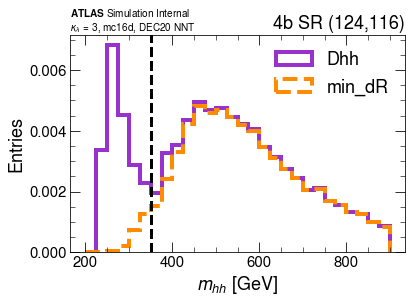

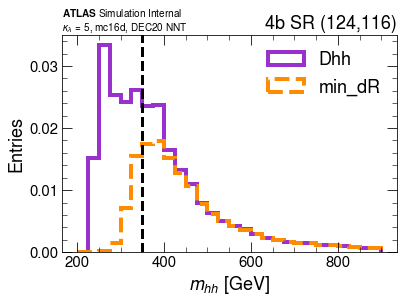

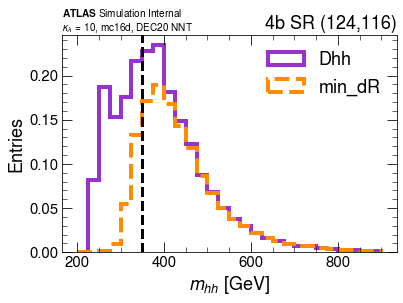

In [146]:
for kl in [3,5,10]:

    ti = "$\mathbf{ATLAS}$ Simulation Internal\n"
    ti += f"$\kappa_\lambda$ = {kl}, {mc}, DEC20 NNT"
    
    m1 = (dhh.Xhh_new<1.6) & (dhh.ntag>=4) & (~dhh.pass_vbf_sel) 
    plt.hist(dhh.loc[m1,'m_hh'],28,(200,900),histtype='step',lw=4,
             color='darkorchid',label=f'Dhh',
             weights=dhh.loc[m1,f'w_k{kl}'])

    m2 = (min_dR.Xhh_new<1.6) & (min_dR.ntag>=4) & (~min_dR.pass_vbf_sel) 
    plt.hist(min_dR.loc[m2,'m_hh'],28,(200,900),histtype='step',lw=4,ls='--',
             color='darkorange',label=f'min_dR',
             weights=min_dR.loc[m2,f'w_k{kl}'])

    plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
    plt.ylabel('Entries',fontsize=18)
    plt.legend(fontsize=18)
    ax = plt.gca()

    ylim = plt.ylim()
    plt.plot([350]*2,ylim,'k--')
    plt.ylim(ylim)

    plt.title('4b SR (124,116)',loc='right')
#     plt.text(.9,.63,f'$\kappa_\lambda$={kl}',ha='right',va='top',
#              transform=ax.transAxes,fontsize=24)
    plt.text(0,1,ti,ha='left',va='bottom',transform=ax.transAxes,fontsize=10)

    plt.savefig(f'{figDir}/m_hh_kl_{kl}_new_SR_dhh_min_dR.pdf',bbox_inches='tight')
    plt.show()

**Valid pairings breakdown**


I'll need to calculate this variable offline lol.

**Command to submit data**

`/tools/submit-grid.sh -i meta/datasets/data_pflowvr.txt -d -x 124 -y 117 -u`